In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import datasets
from torchvision.transforms import v2
from torchsummary import summary

torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [53]:
class DatasetLoader:
    def __init__(self, root='../data', transform=None):
        self.root = root
        self.transform = transform

    def load(self, dataset_name, train=True):
        if dataset_name.lower() == 'mnist':
            dataset = datasets.MNIST
        elif dataset_name.lower() == 'cifar10':
            dataset = datasets.CIFAR10
        else:
            raise ValueError(f"Unsupported dataset: {dataset_name}")

        return dataset(root=self.root, train=train, download=True, transform=self.transform)

# Определение преобразований
transforms = v2.Compose([
    v2.Resize(32), 
    v2.Grayscale(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5,), (0.5,))
])

loader = DatasetLoader(root='../data', transform=transforms)

mnist_trainset = loader.load('mnist', train=True)
mnist_testset = loader.load('mnist', train=False)
cifar_trainset = loader.load('cifar10', train=True)
cifar_testset = loader.load('cifar10', train=False)

Files already downloaded and verified
Files already downloaded and verified


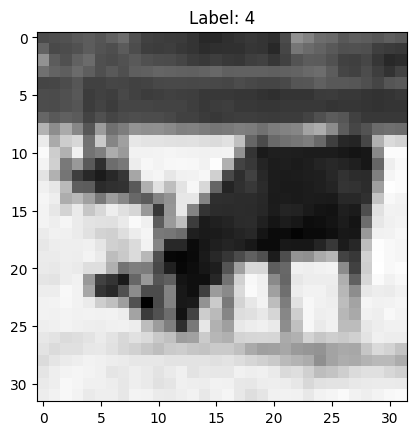

In [85]:
train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1024, shuffle=False)

for images, labels in train_loader:
    # Преобразование тензора в numpy массив
    img = images[0].permute(1, 2, 0).numpy()  # Изменение порядка осей для корректного отображения
    plt.imshow(img, cmap='gray')
    plt.title(f'Label: {labels[0]}')
    plt.show()
    break

In [98]:
class CNNModel(nn.Module):
    def __init__(self, in_channel, hidden_size, output_size):
        super(CNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channel, hidden_size * 4, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_size * 4, hidden_size * 8, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_size * 8, hidden_size * 16, 4, 2, 1),
            nn.ReLU(),
            # nn.Conv2d(hidden_size * 16, hidden_size * 32, 4, 2, 0),
            nn.Flatten(),
            nn.Linear(hidden_size * 16 * 4 * 4, output_size)
        )

    def forward(self, image):
        out = self.model(image)
        return out

In [56]:
if __name__ == "__main__":
    IN_CHANNEL = 1
    HIDDEN_SIZE = 2
    OUTPUT_SIZE = 10
    model = CNNModel(IN_CHANNEL, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    summary(model, input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 16, 16]             136
              ReLU-2            [-1, 8, 16, 16]               0
            Conv2d-3             [-1, 16, 8, 8]           2,064
              ReLU-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 32, 4, 4]           8,224
              ReLU-6             [-1, 32, 4, 4]               0
            Conv2d-7             [-1, 64, 1, 1]          32,832
              ReLU-8             [-1, 64, 1, 1]               0
           Flatten-9                   [-1, 64]               0
           Linear-10                   [-1, 10]             650
Total params: 43,906
Trainable params: 43,906
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.17
Estimated Tot

In [57]:
def train_model(model, train_loader, optimizer, criterion, num_epochs=10, device='cpu'):
    model.to(device)
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        with tqdm(total=len(train_loader), desc=f'Epoch [{epoch+1:>{len(str(num_epochs))}}/{num_epochs}]') as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})
                pbar.update(1)

        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)
        
        print(f'Epoch [{epoch+1:>{len(str(num_epochs))}}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return train_losses, train_accuracies

train_losses, train_accuracies = train_model(model, train_loader, optimizer, criterion, num_epochs=10, device=device)

Epoch [ 1/10]: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.0669]


Epoch [ 1/10], Loss: 0.3580, Accuracy: 88.28%


Epoch [ 2/10]: 100%|██████████| 118/118 [00:32<00:00,  3.59it/s, loss=0.0933]


Epoch [ 2/10], Loss: 0.0716, Accuracy: 97.83%


Epoch [ 3/10]: 100%|██████████| 118/118 [00:31<00:00,  3.77it/s, loss=0.0089]


Epoch [ 3/10], Loss: 0.0538, Accuracy: 98.29%


Epoch [ 4/10]: 100%|██████████| 118/118 [00:31<00:00,  3.75it/s, loss=0.0045]


Epoch [ 4/10], Loss: 0.0396, Accuracy: 98.79%


Epoch [ 5/10]: 100%|██████████| 118/118 [00:31<00:00,  3.69it/s, loss=0.0220]


Epoch [ 5/10], Loss: 0.0377, Accuracy: 98.82%


Epoch [ 6/10]: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s, loss=0.0360]


Epoch [ 6/10], Loss: 0.0302, Accuracy: 99.04%


Epoch [ 7/10]: 100%|██████████| 118/118 [00:32<00:00,  3.60it/s, loss=0.0006]


Epoch [ 7/10], Loss: 0.0290, Accuracy: 99.07%


Epoch [ 8/10]: 100%|██████████| 118/118 [00:31<00:00,  3.72it/s, loss=0.0535]


Epoch [ 8/10], Loss: 0.0272, Accuracy: 99.09%


Epoch [ 9/10]: 100%|██████████| 118/118 [00:32<00:00,  3.67it/s, loss=0.0525]


Epoch [ 9/10], Loss: 0.0291, Accuracy: 99.04%


Epoch [10/10]: 100%|██████████| 118/118 [00:33<00:00,  3.55it/s, loss=0.0044]

Epoch [10/10], Loss: 0.0293, Accuracy: 99.06%


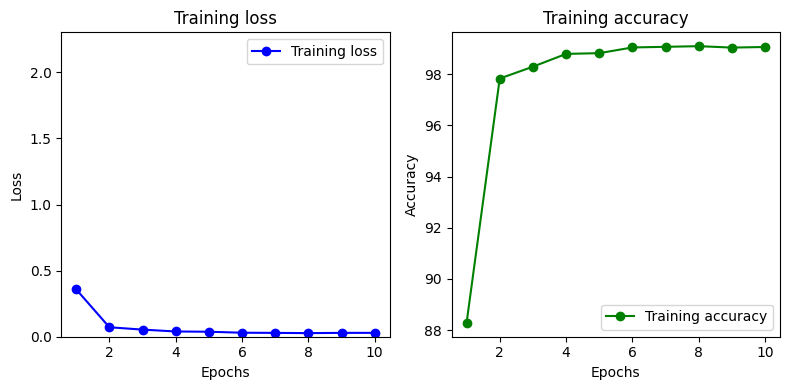

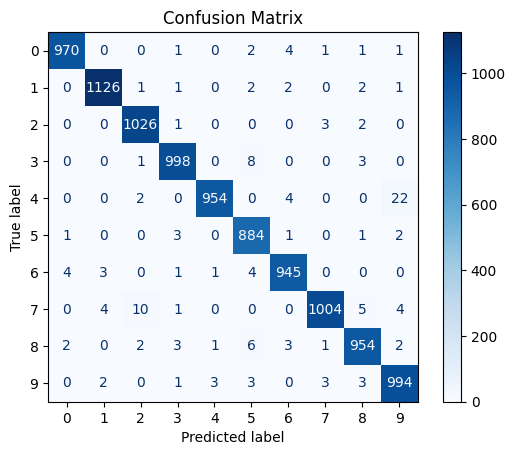

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.97      0.98       982
           5       0.97      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.97      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [61]:
def plot_training_curves(train_losses, train_accuracies, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(8, 4))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, (-np.log(1/10)))
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'go-', label='Training accuracy')
    plt.title('Training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Матрица неточностей
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Отчет о классификации
    print(classification_report(all_labels, all_predictions, target_names=[str(i) for i in range(10)]))

# Пример использования функций
plot_training_curves(train_losses, train_accuracies, 10)
evaluate_model(model, test_loader, device)


### **CIFAR-10**

In [101]:
if __name__ == "__main__":
    IN_CHANNEL = 1
    HIDDEN_SIZE = 2
    OUTPUT_SIZE = 10
    cifar_model = CNNModel(IN_CHANNEL, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cifar_model.parameters(), lr=0.01)
    summary(cifar_model, input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 16, 16]             136
              ReLU-2            [-1, 8, 16, 16]               0
            Conv2d-3             [-1, 16, 8, 8]           2,064
              ReLU-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 32, 4, 4]           8,224
              ReLU-6             [-1, 32, 4, 4]               0
           Flatten-7                  [-1, 512]               0
            Linear-8                   [-1, 10]           5,130
Total params: 15,554
Trainable params: 15,554
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.06
Estimated Total Size (MB): 0.12
----------------------------------------------------------------


Epoch [ 1/10]: 100%|██████████| 49/49 [00:27<00:00,  1.81it/s, loss=1.5967]


Epoch [ 1/10], Loss: 1.8677, Accuracy: 32.32%


Epoch [ 2/10]: 100%|██████████| 49/49 [00:27<00:00,  1.81it/s, loss=1.4698]


Epoch [ 2/10], Loss: 1.5124, Accuracy: 45.90%


Epoch [ 3/10]: 100%|██████████| 49/49 [00:25<00:00,  1.88it/s, loss=1.2799]


Epoch [ 3/10], Loss: 1.3602, Accuracy: 51.91%


Epoch [ 4/10]: 100%|██████████| 49/49 [00:24<00:00,  1.97it/s, loss=1.2478]


Epoch [ 4/10], Loss: 1.2618, Accuracy: 55.45%


Epoch [ 5/10]: 100%|██████████| 49/49 [00:26<00:00,  1.88it/s, loss=1.1907]


Epoch [ 5/10], Loss: 1.1970, Accuracy: 57.99%


Epoch [ 6/10]: 100%|██████████| 49/49 [00:26<00:00,  1.83it/s, loss=1.1508]


Epoch [ 6/10], Loss: 1.1488, Accuracy: 59.66%


Epoch [ 7/10]: 100%|██████████| 49/49 [00:28<00:00,  1.75it/s, loss=1.0878]


Epoch [ 7/10], Loss: 1.0949, Accuracy: 61.77%


Epoch [ 8/10]: 100%|██████████| 49/49 [00:26<00:00,  1.88it/s, loss=1.0573]


Epoch [ 8/10], Loss: 1.0683, Accuracy: 62.63%


Epoch [ 9/10]: 100%|██████████| 49/49 [00:26<00:00,  1.86it/s, loss=0.9858]


Epoch [ 9/10], Loss: 1.0440, Accuracy: 63.57%


Epoch [10/10]: 100%|██████████| 49/49 [00:26<00:00,  1.84it/s, loss=1.0077]


Epoch [10/10], Loss: 1.0055, Accuracy: 64.81%


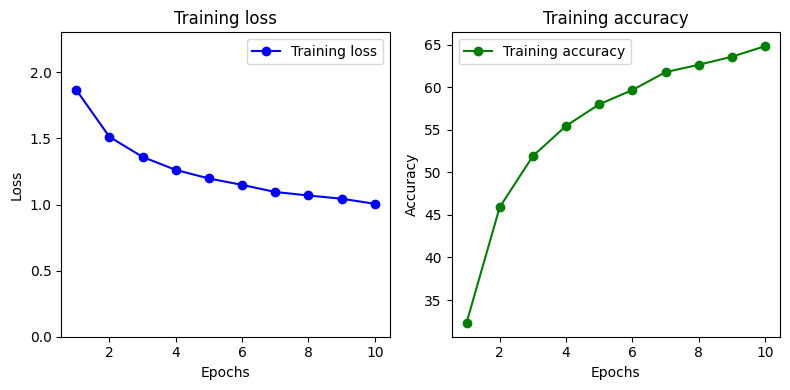

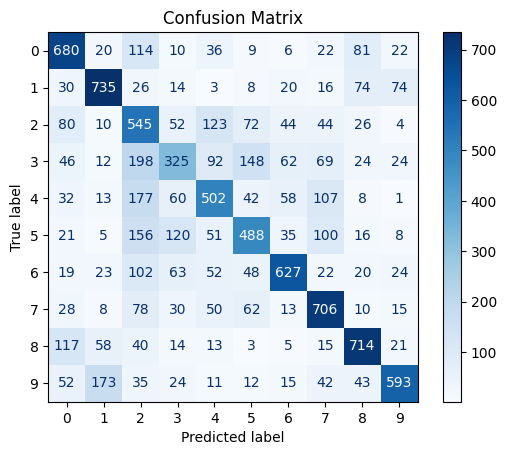

              precision    recall  f1-score   support

           0       0.62      0.68      0.65      1000
           1       0.70      0.73      0.71      1000
           2       0.37      0.55      0.44      1000
           3       0.46      0.33      0.38      1000
           4       0.54      0.50      0.52      1000
           5       0.55      0.49      0.52      1000
           6       0.71      0.63      0.67      1000
           7       0.62      0.71      0.66      1000
           8       0.70      0.71      0.71      1000
           9       0.75      0.59      0.66      1000

    accuracy                           0.59     10000
   macro avg       0.60      0.59      0.59     10000
weighted avg       0.60      0.59      0.59     10000



In [102]:
num_epochs = 10

train_losses, train_accuracies = train_model(cifar_model, train_loader, optimizer, criterion, num_epochs=num_epochs, device=device)
plot_training_curves(train_losses, train_accuracies, num_epochs)
evaluate_model(cifar_model, test_loader, device)